# Boston Housing Dataset

In [1]:
from sklearn.datasets import load_boston
import numpy as np
import pandas as pd
boston = load_boston()
X = boston["data"]
y = boston["target"]
data = pd.DataFrame(X, columns=boston["feature_names"])
data["MEDV"] = y
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


## Split dataset

In [4]:
from sklearn.model_selection import train_test_split
feature_names = data.columns[:-1]
label_name = data.columns[-1]
X, y = data[feature_names], data[label_name]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

## Random Forest Regressor

In [7]:
from sklearn.ensemble import RandomForestRegressor

### No tuning

In [46]:
model = RandomForestRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
np.sqrt(((y_test - y_pred) ** 2).mean()) # RMSE

3.8940713202724493

### Random Search + Cross-validation

In [70]:
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate

In [122]:
n_epoch = 10
result = dict()

for epoch in range(n_epoch):
    max_depth = np.random.randint(low = 1, high = 10)
    max_features = np.random.uniform(low = 0.1, high = 1)
    n_estimators = np.random.randint(low = 10, high = 300)

    model = RandomForestRegressor(bootstrap=True,
                                  criterion='mse',
                                  max_depth=max_depth,
                                  max_features=max_features,
                                  max_leaf_nodes=None,
                                  min_impurity_decrease=0.0,
                                  min_impurity_split=None,
                                  min_samples_leaf=1,
                                  min_samples_split=2,
                                  min_weight_fraction_leaf=0.0,
                                  n_estimators=n_estimators,
                                  n_jobs=-1,
                                  oob_score=False,
                                  random_state=2,
                                  verbose=0,
                                  warm_start=False)

    score = np.sqrt(cross_val_score(model, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_error').mean() * -1)
    result[epoch] = [max_depth, round(max_features, 4), n_estimators, round(score, 4)]

    print(epoch, max_depth, round(max_features, 4), n_estimators, round(score, 4))

df = pd.DataFrame.from_dict(result, orient = 'index', columns = ['max_depth', 'max_features', 'n_estimators', 'RMSE']).sort_values(by = 'RMSE')
df

0 2 0.2495 117 5.2696
1 2 0.2827 148 5.3002
2 4 0.4623 241 3.6454
3 2 0.4173 41 4.8292
4 1 0.808 12 5.9383
5 8 0.3661 172 3.3027
6 1 0.4097 247 6.1395
7 4 0.5553 174 3.7308
8 2 0.9116 214 4.5009
9 6 0.3018 220 3.5774


,max_depth,max_features,n_estimators,RMSE
5,8,0.3661,172,3.3027
9,6,0.3018,220,3.5774
2,4,0.4623,241,3.6454
7,4,0.5553,174,3.7308
8,2,0.9116,214,4.5009
3,2,0.4173,41,4.8292
0,2,0.2495,117,5.2696
1,2,0.2827,148,5.3002
4,1,0.8080,12,5.9383
6,1,0.4097,247,6.1395


### Bayesian Opt + Cross-validation

RandomForestRegressor(3 params tuned) RMSE score:  3.4502
max_depth:  9
max_features :  0.3883
n_estimators :  191


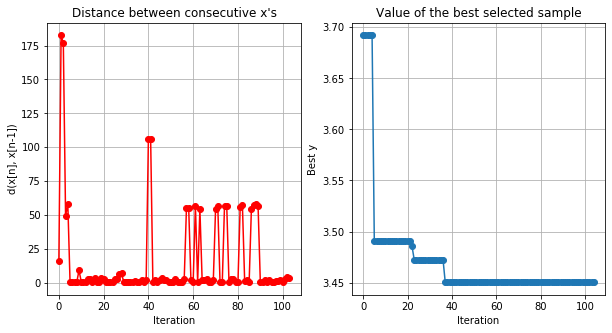

In [173]:
from GPyOpt.methods import BayesianOptimization

bds = [
    {'name': 'max_depth', 'type': 'continuous', 'domain': (1, 10)},
    {'name': 'max_features', 'type': 'continuous', 'domain': (0.1, 1)},
    {'name': 'n_estimators', 'type': 'continuous', 'domain': (10, 300)}
]

def cv_score(parameters):
    parameters = parameters[0]
    score = cross_val_score(
        RandomForestRegressor(
        max_depth = int(parameters[0]),
        max_features=parameters[1],
        n_estimators=int(parameters[2])
        ),
        X_train,
        y_train,
        scoring='neg_mean_squared_error')
    score = np.array(score).mean()
    return np.sqrt(score * -1)

optimizer = BayesianOptimization(f = cv_score,
                                 domain = bds,
                                 model_type = 'GP',
                                 acquisition_type ='EI',
                                 acquisition_jitter = 0.05,
                                 exact_feval = True,
                                 maximize = False)

optimizer.run_optimization(max_iter = 100)
print('RandomForestRegressor(3 params tuned) RMSE score: ', round(optimizer.fx_opt, 4))
print('max_depth: ', int(optimizer.x_opt[0]))
print('max_features : ', round(optimizer.x_opt[1], 4))
print('n_estimators : ', int(optimizer.x_opt[2]))
optimizer.plot_acquisition()
optimizer.plot_convergence()

In [177]:
optimizer.X, optimizer.Y

(array([[7.79393201e+00, 7.12764946e-01, 1.84777311e+02],
        [2.81478710e+00, 7.33380210e-01, 1.99658428e+02],
        [7.35654354e+00, 2.28151078e-01, 1.71802029e+01],
        [9.85913002e+00, 8.54167413e-01, 1.93796234e+02],
        [4.45032857e+00, 8.71625512e-01, 2.42890739e+02],
        [7.79687799e+00, 4.70598262e-01, 1.84580931e+02],
        [7.80218105e+00, 1.00000000e-01, 1.84227450e+02],
        [7.79448461e+00, 4.46628442e-01, 1.84740467e+02],
        [7.59781102e+00, 5.59687696e-01, 1.84577471e+02],
        [8.01304730e+00, 6.22999950e-01, 1.84515640e+02],
        [9.26429419e+00, 8.73380948e-01, 1.93582572e+02],
        [9.61962543e+00, 7.84037273e-01, 1.94361675e+02],
        [9.78366389e+00, 2.60190445e-01, 1.93950814e+02],
        [1.00000000e+01, 2.02122374e-01, 1.93644632e+02],
        [9.96971598e+00, 5.78321501e-01, 1.91227650e+02],
        [9.51527096e+00, 1.00000000e-01, 1.93713958e+02],
        [1.00000000e+01, 3.61870904e-01, 1.94017929e+02],
        [9.858

## XGBoost

In [123]:
from xgboost import XGBRegressor

### No tuning

In [129]:
model = XGBRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
np.sqrt(((y_test - y_pred) ** 2).mean()) # RMSE

4.20481384379128

### Random Search + Cross-validation

In [70]:
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate

In [153]:
n_epoch = 300
result = dict()

for epoch in range(n_epoch):
    max_depth = np.random.randint(low = 1, high = 10)
    n_estimators = np.random.randint(low = 10, high = 300)
    learning_rate = np.random.choice([0.1, 0.01, 0.001, 0.0001, 0.00001])
    gamma = np.random.randint(low = 0, high = 5)
    min_child_weight = np.random.randint(low = 1, high = 10)

    model = XGBRegressor(learning_rate = learning_rate,
                         gamma = gamma,
                         max_depth = max_depth,
                         n_estimators = n_estimators,
                         min_child_weight = min_child_weight)

    score = np.sqrt(cross_val_score(model, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_error').mean() * -1)
    result[epoch] = [max_depth, n_estimators, learning_rate, gamma, min_child_weight, round(score, 4)]

    if epoch % 10 == 0:
        print(epoch, max_depth, n_estimators, learning_rate, gamma, min_child_weight, round(score, 4))

df = pd.DataFrame.from_dict(result, orient = 'index', columns = ['max_depth', 'n_estimators', 'learning_rate', 'gamma', 'min_child_weight', 'RMSE']).sort_values(by = 'RMSE')
df

0 9 172 0.0001 2 8 23.6914
10 5 260 0.01 2 4 4.0055
20 3 59 1e-05 1 8 24.0608
30 4 244 1e-05 2 4 24.0185
40 6 19 0.01 1 7 20.1725
50 4 138 0.1 2 5 3.1895
60 1 178 0.01 4 6 6.6713
70 1 27 0.0001 4 9 24.0148
80 2 226 0.01 1 8 4.7846
90 9 245 0.0001 1 6 23.5279
100 3 269 0.001 3 8 18.7737
110 9 193 0.01 1 8 5.2568
120 6 217 0.001 4 4 19.6615
130 3 164 0.1 0 6 3.1963
140 7 212 0.001 0 7 19.7802
150 5 153 1e-05 3 9 24.0397
160 7 215 1e-05 4 5 24.0254
170 1 230 0.01 3 8 5.4938
180 6 10 0.1 0 7 9.5672
190 5 275 0.1 0 9 3.0744
200 1 275 0.001 1 1 18.8551
210 7 273 0.1 0 1 2.9631
220 2 224 0.01 3 9 4.8172
230 4 81 0.01 0 1 11.5563
240 8 49 0.0001 2 6 23.9635
250 4 267 0.001 2 4 18.7757
260 9 131 0.01 2 7 7.7844
270 2 62 0.01 1 3 13.7477
280 2 165 1e-05 2 3 24.0369
290 4 277 0.01 0 2 3.8377


,max_depth,n_estimators,learning_rate,gamma,min_child_weight,RMSE
210,7,273,0.10000,0,1,2.9631
283,6,196,0.10000,0,6,3.0114
52,3,182,0.10000,2,1,3.0716
190,5,275,0.10000,0,9,3.0744
28,3,209,0.10000,4,1,3.0965
...,...,...,...,...,...,...
273,8,42,0.00001,0,6,24.0645
153,6,42,0.00001,4,8,24.0646
27,9,32,0.00001,1,3,24.0667
194,3,30,0.00001,4,4,24.0672


### Bayesian Opt + Cross-validation

XGBoost(5 params tuned) RMSE score:  3.4125
learning_rate:  0.1
gamma :  0
max_depth :  7
n_estimators :  195
min_child_weight :  6


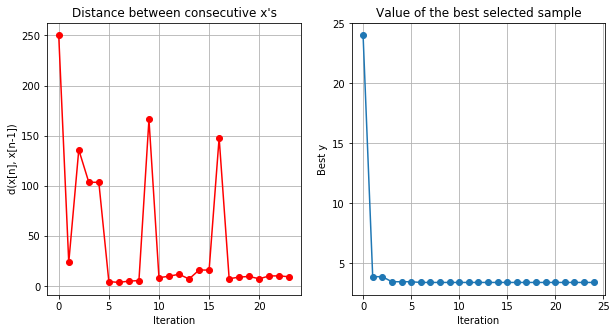

In [163]:
from GPyOpt.methods import BayesianOptimization

bds = [{'name': 'learning_rate', 'type': 'discrete', 'domain': (0.1, 0.01, 0.001, 0.0001, 0.00001)},
        {'name': 'gamma', 'type': 'continuous', 'domain': (0, 5)},
        {'name': 'max_depth', 'type': 'continuous', 'domain': (1, 10)},
        {'name': 'n_estimators', 'type': 'continuous', 'domain': (1, 300)},
        {'name': 'min_child_weight', 'type': 'continuous', 'domain': (1, 10)}
      ]

def cv_score(parameters):
    parameters = parameters[0]
    score = cross_val_score(XGBRegressor(learning_rate=parameters[0],
                                         gamma=int(parameters[1]),
                                         max_depth=int(parameters[2]),
                                         n_estimators=int(parameters[3]),
                                         min_child_weight = int(parameters[4])
                                        ),
                            X_train, y_train, scoring='neg_mean_squared_error')
    score = np.array(score).mean()
    return np.sqrt(score * -1)

optimizer = BayesianOptimization(f=cv_score,
                                 domain=bds,
                                 model_type='GP',
                                 acquisition_type ='EI',
                                 acquisition_jitter = 0.05,
                                 exact_feval=True, 
                                 maximize=False)

optimizer.run_optimization(max_iter = 20)
print('XGBoost(5 params tuned) RMSE score: ', round(optimizer.fx_opt, 4))
print('learning_rate: ', optimizer.x_opt[0])
print('gamma : ', int(optimizer.x_opt[1]))
print('max_depth : ', int(optimizer.x_opt[2]))
print('n_estimators : ', int(optimizer.x_opt[3]))
print('min_child_weight : ', int(optimizer.x_opt[4]))
optimizer.plot_acquisition()
optimizer.plot_convergence()